# Проведение A/B-теста: увеличение выручки

**Цель проекта**: проведение A/B-теста среди пользователей Интернет-магазина

**Этапы реализации проекта:** 

[1. Подготовительный этап: загрузка библиотек, выгрузка данных, изучение общей информации о датафреймах, предобработка данных](#first_stage)
- [1.1. Загрузка библиотек, выгрузка данных, изучение общей информации о датафреймах](#general)

- [1.2. Предобработка данных](#preprocessing)

- [1.3. Создание объединенной таблицы для расчетов](#data_united)

- [1.4. Вывод по этапу](#first_conclusion)


[2. Анализ A/B-теста](#third_stage)

- [2.1. Построение графика кумулятивной выручки по группам](#cumulative_revenue)

- [2.2. Построение графика кумулятивного среднего чека по группам](#cumulative_average)

- [2.3. Построение графика относительного изменения кумулятивного среднего чека группы B к группе A](#cumulative_average_ba)

- [2.4. Построение графика кумулятивного среднего количества заказов по группам](#cumulative_orders)

- [2.5. Построение графика относительного изменения кумулятивного среднего количества заказов группы B к группе A](#cumulative_orders_ba)

- [2.6. Построение точечного графика количества заказов по пользователям](#scatter_orders)

- [2.7. Подсчет 95-й и 99-й перцентили количества заказов на пользователя](#percentiles_orders)

- [2.8. Построение точечного графика стоимостей заказов](#scatter_revenue)

- [2.9. Подсчет 95-й и 99-й перцентили стоимости заказов](#percentiles_revenue)

- [2.10. Подсчет статистической значимости различий в среднем количестве заказов между группами по «сырым» данным](#st_significance_orders_row)

- [2.11. Подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным](#st_significance_revenue_row)

- [2.12. Подсчет статистической значимости различий в среднем количестве заказов между группами по «очищенным» данным](#st_significance_orders_cleaned)

- [2.13. Подсчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным](#st_significance_revenue_cleaned)

- [2.14. Результаты теста, выводы по этапу](#third_conclusion)


[3. Выводы](#conclusion)

<a id="first_stage"> </a>
## Подготовительный этап: загрузка библиотек, выгрузка данных, изучение общей информации о датафреймах, предобработка данных

<a id="general"> </a>
### Загрузка библиотек, выгрузка данных, изучение общей информации о датафреймах

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy import stats as st

In [2]:
#создадим переменную, в которую поместим палитру для графиков

palette = sns.cubehelix_palette(start=.3, rot=-.6, n_colors=15)

In [3]:
#установим ширину отображения столбцов

pd.options.display.max_colwidth = 120

In [4]:
#выгружаем датасеты 

try:
    orders, visitors = (
        pd.read_csv('/datasets/orders.csv'),  #заказы
        pd.read_csv('/datasets/visitors.csv') #посетители
    )  

except:
    orders, visitors = (
        pd.read_csv('C:/datasets/abtests/orders.csv'),  #заказы
        pd.read_csv('C:/datasets/abtests/visitors.csv') #посетители
    )

display('orders', orders.head(5))
display('visitors', visitors.head(5))

'orders'

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


'visitors'

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


**Структура датафрейма `orders`**:
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ

**Структура датафрейма `visitors`**
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

In [5]:
#выведем общую информацию о датафреймах

display('info orders', orders.info())
display('info visitors', visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


'info orders'

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


'info visitors'

None

Большая часть значений во всех датафреймов является числовой. Присутствуют несколько object-столбцов, включая, в том числе, столбец `date`, который необходимо привести к временному типу.

<a id="preprocessing"> </a>
### Предобработка данных

In [6]:
#переведем наименования столбцов в нижний регистр
#добавим нижний пробел для соблюдения стиля

for title in [orders, visitors]:
    title.columns = [x.lower() for x in title.columns.values]

orders.rename(columns = {'transactionid':'transaction_id', 'visitorid':'visitor_id'}, inplace = True)

display('orders', orders.head(5))
display('visitors', visitors.head(5))

'orders'

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


'visitors'

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [7]:
#уберем в датафрейме возможные лишние пробелы

for col in [orders, visitors]:
    title.columns = [x.strip() for x in title.columns.values]

    for col in title.columns:
        if title[col].dtypes == 'object':
            title[col] = title[col].map(lambda x: x.strip())

In [8]:
#преобразуем временные данные 

for df in [orders, visitors]:
    df['date'] = pd.to_datetime(df['date'])
    print(df['date'].dtypes)

datetime64[ns]
datetime64[ns]


In [9]:
#убедимся, что датасеты охватывают одинаковый период времени

for df in [orders, visitors]:
    print(f"охватываемй период: с {min(df['date'].dt.date)} по {max(df['date'].dt.date)}")

охватываемй период: с 2019-08-01 по 2019-08-31
охватываемй период: с 2019-08-01 по 2019-08-31


In [10]:
#убедимся, что в столбцах group присутствуют только группы А и В

for df in [orders, visitors]:
    print(df['group'].unique())

['B' 'A']
['A' 'B']


In [11]:
#Проверим наличие пропусков в датафреймах

orders.isna().sum(), visitors.isna().sum()

(transaction_id    0
 visitor_id        0
 date              0
 revenue           0
 group             0
 dtype: int64,
 date        0
 group       0
 visitors    0
 dtype: int64)

In [12]:
#Проверим наличие явных дубликатов в датафреймах

orders.duplicated().sum(), visitors.duplicated().sum()

(0, 0)

В используемых датафреймах отсутствуют дубликаты, а также пропуски. Среди всех данных имеются два численных столбца - `revenue` и `visitors` Выявим, имеются ли среди них аномалии.

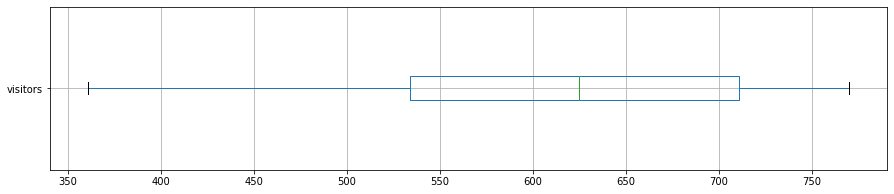

In [13]:
#выведем диаграмму размаха столбца visitors датафрейма visitors

visitors.boxplot(column='visitors', vert = False, figsize=(15, 3));

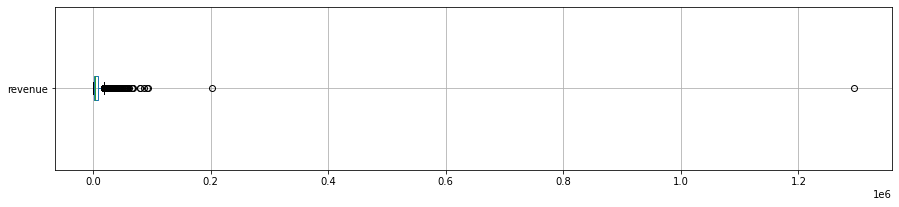

In [14]:
#выведем диаграмму размаха столбца revenue датафрейма orders

orders.boxplot(column='revenue', vert = False, figsize=(15, 3));

Данные в столбце `visitors` не выходят за пределы размаха, однако в столбце `revenue` возможны выбросы. Вернемся к ним на следующем этапе.

Для успешного проведения A/B теста необходимы следующие условия:

- количество пользователей в различных группах различается не более, чем на 1%;
- различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- попавший в одну из групп посетитель остаётся в этой группе до конца теста.

Для начала убедимся, что количество пользователей в обеих группах совпадает, а также что пользователи, которые могли по ошибке оказаться и в группе А, и в группе В, отсутствуют.

In [15]:
#проверим, как много пользователей и посетителей оказалось в обеих группах

unique_buyers_by_group = (
    orders
    .pivot_table(index='group', 
                       values='visitor_id', 
                       aggfunc='nunique')
    .rename(columns={'visitor_id': 'visitors'})
)

visitors_by_group = (
    visitors
    .pivot_table(index='group', 
                 values='visitors', 
                 aggfunc='sum')
)

buyers_by_group = (
    orders
    .pivot_table(index='group', 
                 values='visitor_id', 
                 aggfunc='count')
    .rename(columns={'visitor_id': 'visitors'})

)

display('Уникальных покупателей', unique_buyers_by_group)
display('Всего покупателей', buyers_by_group)
display('Bсего посетителей', visitors_by_group)

'Уникальных покупателей'

,visitors
group,
A,503
B,586


'Всего покупателей'

,visitors
group,
A,557
B,640


'Bсего посетителей'

,visitors
group,
A,18736
B,18916


In [16]:
#сравним полученные по группам результаты

display('уникальных покупателей группы В больше на: {:.2%}'
        .format((unique_buyers_by_group['visitors'][1] \
                 / unique_buyers_by_group['visitors'][0]) - 1)
       )

display('покупателей группы В больше на: {:.2%}'
        .format((buyers_by_group['visitors'][1] \
                 / buyers_by_group['visitors'][0]) - 1)
       )

display(
'посетителей группы В больше на: {:.2%}'
        .format(visitors_by_group['visitors'][1] \
                / visitors_by_group['visitors'][0] - 1 )
)

'уникальных покупателей группы В больше на: 16.50%'

'покупателей группы В больше на: 14.90%'

'посетителей группы В больше на: 0.96%'

Количество посетителей интернет-магазина обеих групп примерно равно, разница не превышает 1%, что соответствует условиям теста. Однако, группа В гораздо активнее совершает покупки - на 16,5%. Учитывая, что значительную часть теста мы будем работать именно с данными о покупках, такая ассиметрия может негативно повлиять на итоговый результат.  

In [17]:
#выведем, какой процент составляют покупатели от всех посетителей интернет-магазина

display('% уникальных покупателей от посетителей', (unique_buyers_by_group / visitors_by_group).round(3))
display('% Покупателей от посетителей', (buyers_by_group / visitors_by_group).round(3))

'% уникальных покупателей от посетителей'

,visitors
group,
A,0.027
B,0.031


'% Покупателей от посетителей'

,visitors
group,
A,0.030
B,0.034


По условиям нам не обозначено, данные о каких именно посетителях находятся в стобце visitors одноименного датафрейма: уникальных или всех, кто посетил интернет-магазин более одного раза в день. Именно поэтому в расчетах процентного соотношения покупателей от посетителей были взяты как уникальные, так и все пользователи. Тем не менее, значительной разницы между ними не обнаружено: общее количесто покупателей достаточно мало и составляет около 3% всех посетителей в каждой из групп. 

In [18]:
#выявим возможное нахождение пользователей в одних и тех же группах

common_users = (
    set(orders
    .query('group == "A"')['visitor_id'])
    .intersection(set(orders.query('group == "B"')['visitor_id'])
                 )
)

len(common_users)

58

In [19]:
#проверим, какую часть пользователей составляют полученные значения,
#а также какой процент всех данных приходится на них

display('пересекающихся пользователей: {:.2%}'
        .format(len(common_users) / orders['visitor_id'].nunique()))

display('всего заказов на пересекающихся пользователей: {:.2%}'
        .format(len(common_users) / len(orders)))

'пересекающихся пользователей: 5.63%'

'всего заказов на пересекающихся пользователей: 4.85%'

Пользователей, которые попали одновременно в обе исследуемые группы, оказалось более 5%. С одной стороны, их присутствие может искажать характеристки поведения обеих групп. С другой стороны, общее число посетителей в датафрейме `visitors` включает, в том числе, и этих пользователей, и при удалении пользователей из данных `orders`, необходимо также скорректировать число посетителей, однако, датафрейм `visitors` включает только обобщенные даты по дням без возможности установить, когда и сколько раз каждый из покупателей посещал интернет-магазин. Тем не менее, как было установлено выше, число покупателей среди всех посетителей является не столь значительным и их сокращение на 5% не изменит общую долю посетителей, однако обеспечит большую точность данных при расчетах платежных метрик.

In [20]:
#удаляем пересекающихся пользователей 

display('число записей до удаления:', len(orders))
orders = orders.query('visitor_id not in @common_users')
display('число записей после удаления:', len(orders))

'число записей до удаления:'

1197

'число записей после удаления:'

1016

<a id="data_united"> </a>                  

### Создание объединенной таблицы для расчетов

Для дальнейших расчетов нам потребуется создать объединенную таблицу, в которую войдут:
- количество покупателей для каждой группы по датам;
- информация о количестве заказов для каждой группы по датам;
- информация о суммарной выручке для каждой группы по датам;
- кумулятивное число заказов для каждой группы по датам;
- кумулятивная выручка для каждой группы по датам;
- количество пользователей для каждой группы по датам;
- кумулятивное количество пользователей для каждой группы по датам

In [21]:
#создадим переменные для каждой группы, куда войдут данные о числе покупателей, 
#числе покупок и сумме выручки по дням

orders_per_date_A = (
    orders.query('group == "A"')
    .groupby('date', as_index=False)
    .agg({'transaction_id': 'nunique', 
          'visitor_id': 'nunique', 
          'revenue': 'sum'})
    .rename(columns={'transaction_id': 'orders_A', 
                     'visitor_id': 'buyers_A', 
                     'revenue': 'revenue_A'})
)

orders_per_date_B = (
    orders.query('group == "B"')
    .groupby('date', as_index=False)
    .agg({'transaction_id': 'nunique', 
          'visitor_id': 'nunique', 
          'revenue': 'sum'})
    .rename(columns={'transaction_id': 'orders_B', 
                     'visitor_id': 'buyers_B', 
                     'revenue': 'revenue_B'})
)
display('A', orders_per_date_A.head(3))
display('B', orders_per_date_B.head(3))

'A'

,date,orders_A,buyers_A,revenue_A
0,2019-08-01,23,19,142779
1,2019-08-02,19,18,91602
2,2019-08-03,24,24,112473


'B'

,date,orders_B,buyers_B,revenue_B
0,2019-08-01,17,17,59758
1,2019-08-02,23,22,162043
2,2019-08-03,14,14,67049


In [22]:
#создадим переменные, куда войдут кумулятивные данные по каждой группе

cmlt_orders_per_date_A = (
    orders_per_date_A
    .apply(lambda x: orders_per_date_A[orders_per_date_A['date'] <= x['date']]
                            .agg({'date' : 'max', 
                                  'orders_A' : 'sum', 
                                  'buyers_A' : 'sum', 
                                  'revenue_A' : 'sum'}), axis=1)
    .rename(columns={'orders_A': 
                     'cmlt_orders_A', 
                     'buyers_A': 'cmlt_buyers_A', 
                     'revenue_A': 'cmlt_revenue_A'})
)


cmlt_orders_per_date_B = (
    orders_per_date_B
    .apply(lambda x: orders_per_date_B[orders_per_date_B['date'] <= x['date']]
                            .agg({'date' : 'max', 
                                  'orders_B' : 'sum', 
                                  'buyers_B' : 'sum', 
                                  'revenue_B' : 'sum'}), axis=1)
    .rename(columns={'orders_B': 'cmlt_orders_B', 
                     'buyers_B': 'cmlt_buyers_B', 
                     'revenue_B': 'cmlt_revenue_B'})
)

display('A', cmlt_orders_per_date_A.head(3))
display('B', cmlt_orders_per_date_B.head(3))

'A'

,date,cmlt_orders_A,cmlt_buyers_A,cmlt_revenue_A
0,2019-08-01,23,19,142779
1,2019-08-02,42,37,234381
2,2019-08-03,66,61,346854


'B'

,date,cmlt_orders_B,cmlt_buyers_B,cmlt_revenue_B
0,2019-08-01,17,17,59758
1,2019-08-02,40,39,221801
2,2019-08-03,54,53,288850


In [23]:
#выделим данные по посетителям в каждой группе в отдельные переменные

visitors_per_date_A = (
    visitors
    .query('group == "A"')[['date', 'visitors']]
    .rename(columns={'visitors': 'visitors_A'})
)

visitors_per_date_B = (
    visitors
    .query('group == "B"')[['date', 'visitors']]
    .rename(columns={'visitors': 'visitors_B'})
)
                       
display('A', visitors_per_date_A.head(3))
display('B', visitors_per_date_B.head(3))

'A'

,date,visitors_A
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507


'B'

,date,visitors_B
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509


In [24]:
#создадим переменные, куда войдут кумулятивные данные по каждой группе

cmlt_visitors_per_date_A = (
    visitors_per_date_A
    .apply(lambda x: visitors_per_date_A[visitors_per_date_A['date'] <= x['date']]
           .agg({'date' : 'max', 'visitors_A' : 'sum'}), axis=1)
    .rename(columns={'visitors_A': 'cmlt_visitors_A'})
)


cmlt_visitors_per_date_B = (
    visitors_per_date_B
    .apply(lambda x: visitors_per_date_B[visitors_per_date_B['date'] <= x['date']]
           .agg({'date' : 'max', 'visitors_B' : 'sum'}), axis=1)
    .rename(columns={'visitors_B': 'cmlt_visitors_B'})
)

display('A', cmlt_visitors_per_date_A.head(3))
display('B', cmlt_visitors_per_date_B.head(3))

'A'

,date,cmlt_visitors_A
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845


'B'

,date,cmlt_visitors_B
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803


In [25]:
#объединим полученные таблицы

data = (
    orders_per_date_A
    .merge(cmlt_orders_per_date_A, 
           left_on='date', 
           right_on='date', 
           how='left')
    .merge(visitors_per_date_A, 
           left_on='date', 
           right_on='date', 
           how='left')
    .merge(cmlt_visitors_per_date_A, 
           left_on='date', 
           right_on='date', 
           how='left')
    .merge(orders_per_date_B, 
           left_on='date', 
           right_on='date', 
           how='left')
    .merge(cmlt_orders_per_date_B, 
           left_on='date', 
           right_on='date', 
           how='left')
    .merge(visitors_per_date_B, 
           left_on='date', 
           right_on='date', 
           how='left')
    .merge(cmlt_visitors_per_date_B, 
           left_on='date', 
           right_on='date', 
           how='left')
).sort_values(by=['date'])

data.head(5)

,date,orders_A,buyers_A,revenue_A,cmlt_orders_A,cmlt_buyers_A,cmlt_revenue_A,visitors_A,cmlt_visitors_A,orders_B,buyers_B,revenue_B,cmlt_orders_B,cmlt_buyers_B,cmlt_revenue_B,visitors_B,cmlt_visitors_B
0,2019-08-01,23,19,142779,23,19,142779,719,719,17,17,59758,17,17,59758,713,713
1,2019-08-02,19,18,91602,42,37,234381,619,1338,23,22,162043,40,39,221801,581,1294
2,2019-08-03,24,24,112473,66,61,346854,507,1845,14,14,67049,54,53,288850,509,1803
3,2019-08-04,11,11,41176,77,72,388030,717,2562,14,13,96890,68,66,385740,770,2573
4,2019-08-05,22,22,86383,99,94,474413,756,3318,21,21,89908,89,87,475648,707,3280


<a id="first_conclusion"> </a>                  

### Вывод по этапу

- наименования столбцов приведены к единому стилю, удалены возможные пробелы, выявлено отсутствие дубликатов и пропусков, отмечена возможная аномалия в столбце `revenue`, ряд данных приведен к временному типу;
- выявлена разница между количеством пользователей и покупателей в каждой из групп, процентное соотношение покупателей от пользователей, обнаружены и удалены из датафрейма пересекающиеся пользователи;
- создана отдельная таблица для использования в дальнейших расчетах, куда вошли общие и кумулятивные данные по дням по посетителям и покупателям из каждой группы.

<a id="third_stage"> </a>   


## Анализ A/B-теста

<a id="cumulative_revenue"> </a>   


### Построение графика кумулятивной выручки по группам

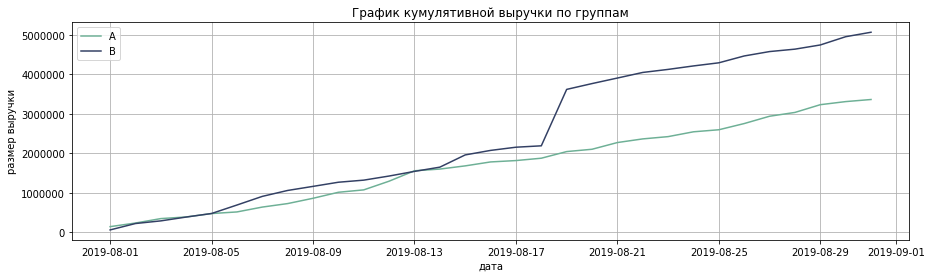

In [26]:
#постром график

plt.figure(figsize=(15,4))
plt.plot(data['date'], 
         data['cmlt_revenue_A'], 
         label='A', 
         color=palette[5])
plt.plot(data['date'], data['cmlt_revenue_B'], 
         label='B', 
         color=palette[12])
plt.xlabel('дата')
plt.ylabel('размер выручки')
plt.legend(loc = 'best')
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True)
plt.title('График кумулятивной выручки по группам')
plt.show()

Выручка групп А и В была практически одинаковой в первые пять дней, после чего выручка группы В постепенно начала уходить в отрыв, который резко увеличился к двадцатым числам августа - вероятно, в этот период были сделаны особо дорогие заказы или их число увеличилось. Рост выручки группы А характеризуется большей плавностью, без значительных скачков. По итогам месяца кумулятивная выручка группы В превалировала над кумулятивной выручкой группы А почти на 2 млн единиц. 

<a id="cumulative_average"> </a>   


### Построение графика кумулятивного среднего чека по группам

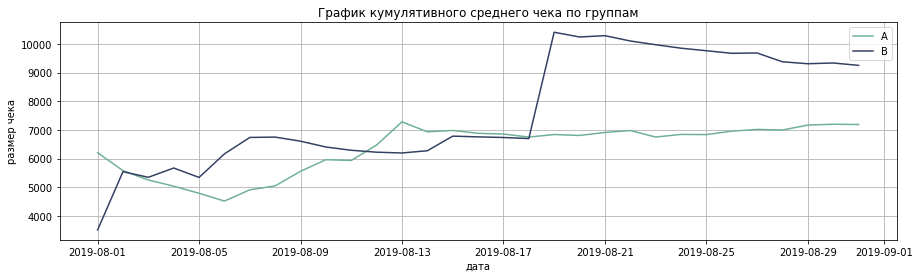

In [27]:
#для получения размера среднего чека по группам разделим выручку на число заказов

plt.figure(figsize=(15,4))
plt.plot(data['date'], data['cmlt_revenue_A']\
         /data['cmlt_orders_A'], 
         label='A', 
         color=palette[5])
plt.plot(data['date'], data['cmlt_revenue_B']\
         /data['cmlt_orders_B'], 
         label='B', 
         color=palette[12])
plt.xlabel('дата')
plt.ylabel('размер чека')
plt.legend(loc = 'best')
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True)
plt.title('График кумулятивного среднего чека по группам')
plt.show()

После снижения в первые пять дней средний размер чека группы А начал увеличиваться, достигнув максимального значения 13 августа в примерно 7300 единиц, превысив на тысячу единиц дневной показатель противоположной группы. Затем показатель незначительно уменьшился и почти до конца месяца стабилизировался на отметке, близкой к 7000 единиц, наметив небольшой рост по итогам периода. 

Как и в предыдущем графике, размер среднего кумулятивного чека группы В стабильно выше среднего кумулятивного чека второй группы пользователей. До 18 августа график находился в скачкообразном состоянии, переодически то понижаясь, то возрастая. После резкого роста с 7000 до более 10000 единиц, обусловленного, по всей видимости, особо дорогим заказом, средний чек группы В начал плавное снижение, остановившись к началу сентября на отметке чуть более 9000 единиц. 

<a id="cumulative_average_ba"> </a>   


### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

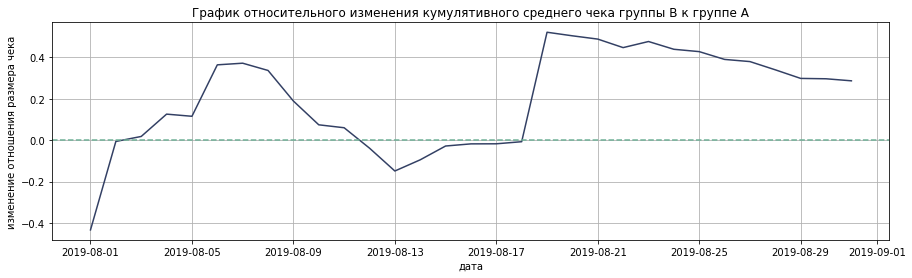

In [28]:
#построим график 

plt.figure(figsize=(15,4))
plt.plot(data['date'], 
         (data['cmlt_revenue_B']/data['cmlt_orders_B'])\
         /(data['cmlt_revenue_A']/data['cmlt_orders_A'])-1, 
         color=palette[12])
plt.xlabel('дата')
plt.ylabel('изменение отношения размера чека')
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.axhline(y=0, color=palette[5], linestyle='--') 
plt.show()

Как и на предыдущем графике, практически в течение всего периода отношение среднего чека группы В к группе А является положительным. Единственные исключения - первые дни августа и период около 13 числа: вполне возможно, что именно в это время была проведена особая работа с пользователями из этой группы, что повлияло на совершение дорогих заказов или роста их количества. 

<a id="cumulative_orders"> </a>   


### Построение графика кумулятивного среднего количества заказов по группам

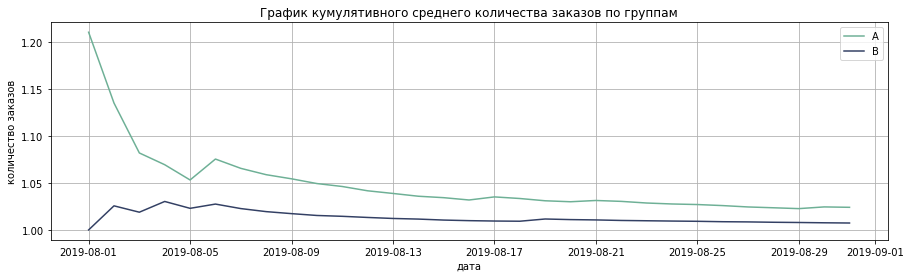

In [29]:
#для выявления среднего количества заказов разделим количество заказов на число покупателей

plt.figure(figsize=(15,4))
plt.plot(data['date'], data['cmlt_orders_A']\
         /data['cmlt_buyers_A'], label='A', color=palette[5])
plt.plot(data['date'], data['cmlt_orders_B']\
         /data['cmlt_buyers_B'], label='B', color=palette[12])
plt.xlabel('дата')
plt.ylabel('количество заказов')
plt.legend(loc = 'best')
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True)
plt.title('График кумулятивного среднего количества заказов по группам')
plt.show()

В отличие от предыдущих графиков, для группы А в среднем характерно чуть большее число заказов, чем для группы В. Однако, первая группа начала период с резкого падения показателя - с 1.2 до 1,05 заказов на покупателя, после чего продолжила небольшое снижение, пракически стабилизировавшись с середины месяца на отметке в примерно 1.03 заказа на покупателя. Группа В, напротив, начала период с роста, однако значительное время ее показатель также стабилен и близок к 1.01 заказа. 

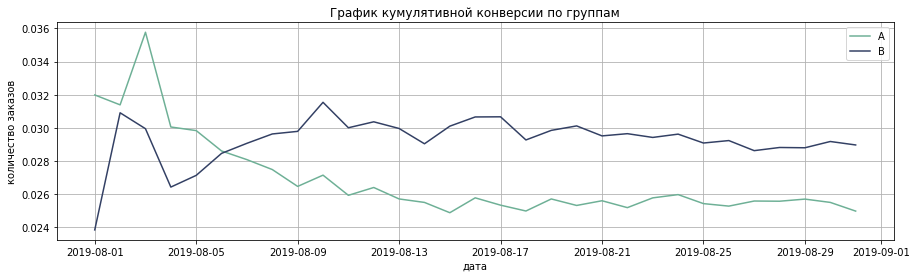

In [30]:
#построим график кумулятивной конверсии 

plt.figure(figsize=(15,4))
plt.plot(data['date'], data['cmlt_orders_A'] \
         / data['cmlt_visitors_A'], 
         label='A', 
         color=palette[5])
plt.plot(data['date'], data['cmlt_orders_B'] \
         / data['cmlt_visitors_B'], 
         label='B', 
         color=palette[12])
plt.xlabel('дата')
plt.ylabel('количество заказов')
plt.legend(loc = 'best')
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True)
plt.title('График кумулятивной конверсии по группам')
plt.show()

После колебаний в первые несколько дней кумулятивная конверсия группы В в целом зафиксировалась на отметке в 3%, чуть снзившись к концу месяца. Группа А, начав с неплохого старта, затем продемонстрировала негативный рост, опустившись в итоге до 2,5%. 

<a id="cumulative_orders_ba"> </a>   


### Построение графика относительного изменения кумулятивного среднего количества заказов группы B к группе A

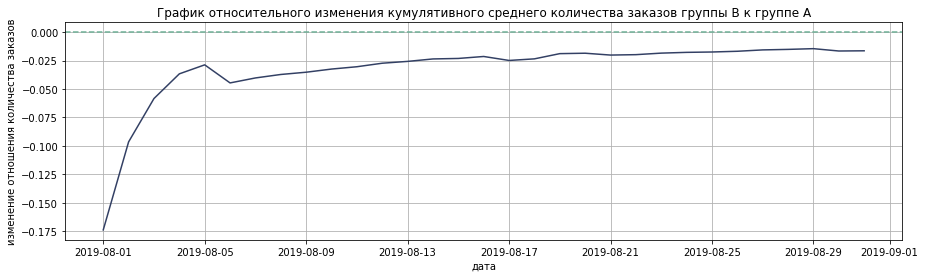

In [31]:
#для построения графика разделим среднее количества заказов группы В на аналогичный показатель группы А

plt.figure(figsize=(15,4))
plt.plot(data['date'], (data['cmlt_orders_B']/data['cmlt_buyers_B'])\
         /(data['cmlt_orders_A']/data['cmlt_buyers_A'])-1, color=palette[12])
plt.xlabel('дата')
plt.ylabel('изменение отношения количества заказов')
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True)
plt.title('График относительного изменения кумулятивного среднего количества заказов группы B к группе A')
plt.axhline(y=0, color=palette[5], linestyle='--') 
plt.show()

За весь период кумулятивное среднее количество заказов группы В так и не превысило аналогичный показатель для А, однако продемонстрировало стабильный, хотя и не слишком ярко выраженный рост практически с самого начала месяца.

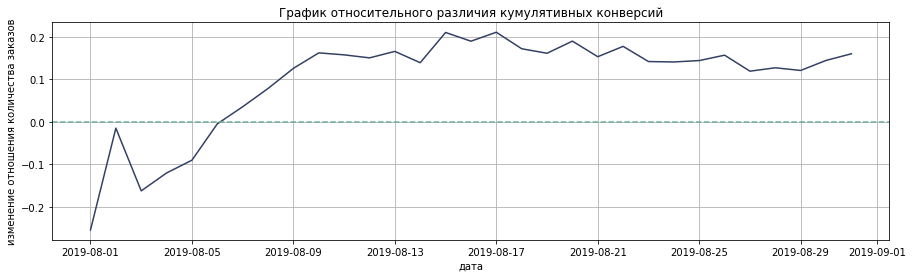

In [32]:
#Построим график относительного различия кумулятивных конверсий

plt.figure(figsize=(15,4))
plt.plot(data['date'], (data['cmlt_orders_B']/data['cmlt_visitors_B'])\
         /(data['cmlt_orders_A']/data['cmlt_visitors_A'])-1, color=palette[12])
plt.xlabel('дата')
plt.ylabel('изменение отношения количества заказов')
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True)
plt.title('График относительного различия кумулятивных конверсий')
plt.axhline(y=0, color=palette[5], linestyle='--') 
plt.show()

График подтверждает: отношение кумулятивной конверсии В к аналогичному показателю группы А на большей части пути стабильно с небольшой динамикой и начиная с 6 августа приобретает положительное значение. 

<a id="scatter_orders"> </a>   


### Построение точечного графика количества заказов по пользователям

In [33]:
#создадим переменную, в которую вынесем число заказов по пользователям

ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
    .rename(columns={'transaction_id': 'orders', 'visitor_id': 'buyers'})
)

ordersByUsers.sort_values(by='orders', ascending=False).head(5)

,buyers,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


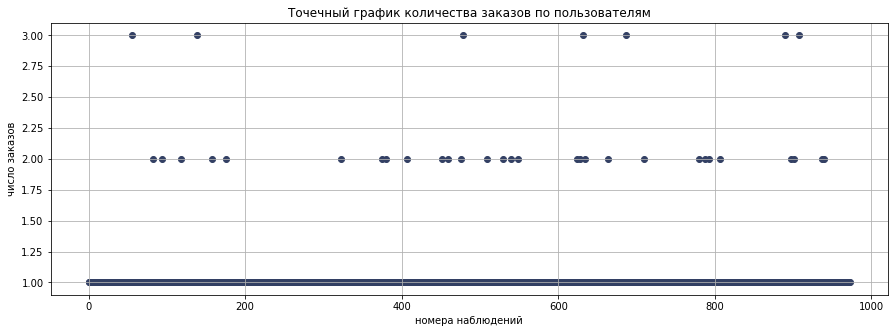

In [34]:
#выведем данные на график 

plt.figure(figsize=(15,5))
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'], color=palette[12]) 
plt.xlabel('номера наблюдений')
plt.ylabel('число заказов')
plt.grid(True)
plt.title('Точечный график количества заказов по пользователям')
plt.show()

Большинство пользователей предпочитают совершать 1-2 заказа, три заказа встречаются уже в единичных случаях.

<a id="percentiles_orders"> </a>   


### Подсчет 95-й и 99-й перцентили количества заказов на пользователя

In [35]:
#подсчитаем перцентили с помощью метода percentile()

np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

Согласно полученным данным, на 5% покупателей приходится более 1 заказа, а более 2 покупок совершил всего 1% пользователей.

<a id="scatter_revenue"> </a>   

### Построение точечного графика стоимостей заказов

Диаграмма размаха, построенная в предыдущей главе, показала возможное наличие выбросов. 
Оценим стоимость заказов, построив точечный график по данным orders

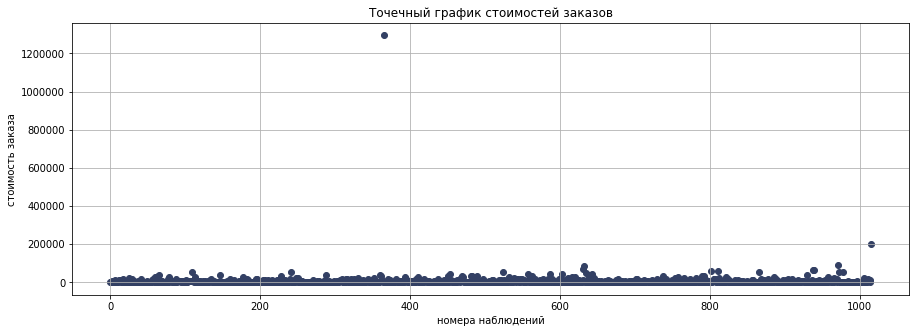

In [36]:
#выведем данные по стоимости заказов на график 

plt.figure(figsize=(15,5))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], color=palette[12]) 
plt.xlabel('номера наблюдений')
plt.ylabel('стоимость заказа')
plt.grid(True)
plt.title('Точечный график стоимостей заказов')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Действительно, на графике значительно выбиваются два заказа: на 200 тысяч и на более чем 1,2 млн единиц. Есть несколько отдельных заказов, которые также, согласно графику, превышают общие показатели, но незначительно.

<a id="percentiles_revenue"> </a>   


### Подсчет 95-й и 99-й перцентили стоимости заказов

In [37]:
#подсчитаем перцентили с помощью метода percentile()

np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Согласно полученным данным, 95% заказов не превышают 26.8 тысяч, и всего 1% заказов имеют чек дороже почти 54 тыс. единиц. 

<a id="st_significance_orders_row"> </a>   


### Подсчет статистической значимости различий в среднем количестве заказов между группами по «сырым» данным

Сформулируем гипотезы:
- Н0 - статистически значимые различия в среднем числе заказов между группами А и В отсутствуют. 
- альтернативная гипотеза - имеются различия в среднем количестве заказов между группами.

In [38]:
#создадим переменные для каждой группы с информацией о числе заказов

orders_by_user_A = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
    .rename(columns={'transaction_id': 'orders'})
)

orders_by_user_B = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
    .rename(columns={'transaction_id': 'orders'})
)

display(orders_by_user_A.sort_values(by='orders', ascending=False).head(5))
display(orders_by_user_B.sort_values(by='orders', ascending=False).head(5))

,visitor_id,orders
58,611059232,3
211,2108163459,3
310,2988190573,3
409,3908431265,3
416,3967698036,3


,visitor_id,orders
347,2742574263,3
33,249864742,3
486,3935952912,2
256,2025197455,2
418,3332057097,2


Подготовим выборки к проверке критерием Манна-Уитни и добавим информацию о количестве заказов всех посетителей:  число элементов в каждой переменной будут означать это количество пользователей, сумма всех элементов — количество заказов, в том числе с учетом нулевых.

In [39]:
#создадим два объекта с информацией о количестве заказов всех посетителей по группам

sample_A = pd.concat(
    [
        orders_by_user_A['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_A'].sum() - len(orders_by_user_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_B = pd.concat(
    [
        orders_by_user_B['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_B'].sum() - len(orders_by_user_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_A.head(3), sample_B.head(3)

(0    1
 1    1
 2    1
 Name: orders, dtype: int64,
 0    1
 1    1
 2    1
 Name: orders, dtype: int64)

Для подсчета статистической значимости различий в среднем количестве заказов между группами используем непараметрический тест Манна-Уитни, который сравнит значения, выстроенные по рангам. Критическим уровнем статистической значимости для теста примем 0.05.

In [40]:
#проверим критерием Манна-Уитни статистическую значимость различий 
#в среднем количестве заказов между группами 

pvalue = st.mannwhitneyu(sample_A, sample_B)[1]

display("p-value равен: {0:.3f}".format(pvalue))
if pvalue < 0.05:
    display('отвергаем нулевую гипотезу: разница статистически значима')
else:
    display(
        'не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

display("относительный прирост группы В равен {:.2%}".format(sample_B.mean() / sample_A.mean() - 1))

'p-value равен: 0.011'

'отвергаем нулевую гипотезу: разница статистически значима'

'относительный прирост группы В равен 15.98%'

Полученный р-value меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, можно отвергнуть. 
Относительный прирост среднего числа заказов группы B равен 16%

<a id="st_significance_revenue_row"> </a>   

### Подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Вновь обозначим нулевую гипотезу: статистически значимые различия в среднем чеке заказов между группами А и В отсутствуют. Альтернативная будет предусматривать наличие различий.

In [41]:
#проверим критерием Манна-Уитни статистическую значимость различий
#передадим данные о выручке с заказов

pvalue = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], \
                         orders[orders['group']=='B']['revenue'])[1]

display("p-value равен: {0:.3f}".format(pvalue))
if pvalue < 0.05:
    display('отвергаем нулевую гипотезу: разница статистически значима')
else:
    display(
        'не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

display("относительный прирост группы В равен {:.2%}"
        .format(orders[orders['group']=='B']['revenue'].mean()\
                /orders[orders['group']=='A']['revenue'].mean() - 1))

'p-value равен: 0.829'

'не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'

'относительный прирост группы В равен 28.66%'

В данном случае р-value значительно превышает 0.05, нулевую гипотезу не отвергаем, однако средний чек группы B почти на 29% выше среднего чека группы A.

<a id="st_significance_orders_cleaned"> </a>   


### Подсчет статистической значимости различий в среднем количестве заказов между группами по «очищенным» данным

Ранее нами было установлено, что 5% заказов по своей стоимости превышают почти 27 тысяч единиц, из которых 1% заказов имеют чек дороже 54 тысячи единиц, а также то, что на 5% покупателей приходится 2 заказа, а 1% пользователей совершили 3 заказа. 

Примем за аномальных пользователей тех, кто совершил более 1 заказа или или осуществил заказ дороже 26 785 единиц.

In [42]:
#выделим таких пользователей в отдельную группу 

abnormal_users_number = pd.concat(
    [
        orders_by_user_A[orders_by_user_A['orders'] > 1]['visitor_id'],
        orders_by_user_B[orders_by_user_B['orders'] > 1]['visitor_id'],
    ],
    axis=0
)

abnormal_users_expensive = orders[orders['revenue'] > 26785]['visitor_id']

abnormal_users = (
    pd.concat([abnormal_users_number, abnormal_users_expensive], axis=0)
    .drop_duplicates()
    .sort_values()
)

display(abnormal_users.head(5))
display('всего аномальных пользователей:', abnormal_users.shape[0])

'процент от всех пользователей: {0:.1f}'.format(abnormal_users.shape[0] /\
                                                orders['visitor_id'].nunique() * 100)

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitor_id, dtype: int64

'всего аномальных пользователей:'

86

'процент от всех пользователей: 8.8'

В сумме аномальные пользователи составили около 9% от всех пользователей, включенных в данные. Проверим, как изменится статистическая зависимость, исключив их из анализа

In [43]:
#повторим группировку по числу заказов, исключив аномальных пользователей

sample_A_fltr = pd.concat(
    [
        orders_by_user_A[np.logical_not(orders_by_user_A['visitor_id'].isin(abnormal_users))
                        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_A'].sum() - len(orders_by_user_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_B_fltr = pd.concat(
    [
    orders_by_user_B[np.logical_not(orders_by_user_B['visitor_id'].isin(abnormal_users))
                        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_B'].sum() - len(orders_by_user_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_A_fltr.head(3), sample_B_fltr.head(3)

(0    1
 1    1
 2    1
 Name: orders, dtype: int64,
 0    1
 1    1
 2    1
 Name: orders, dtype: int64)

In [44]:
#проверим критерием Манна-Уитни статистическую значимость различий 
#в среднем количестве заказов между группами 

pvalue = st.mannwhitneyu(sample_A_fltr, sample_B_fltr)[1]

display("p-value равен: {0:.3f}".format(pvalue))
if pvalue < 0.05:
    display('отвергаем нулевую гипотезу: разница статистически значима')
else:
    display(
        'не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

display("относительный прирост группы В равен {:.2%}".format(sample_B_fltr.mean() /\
                                                             sample_A_fltr.mean() - 1))

'p-value равен: 0.016'

'отвергаем нулевую гипотезу: разница статистически значима'

'относительный прирост группы В равен 17.39%'

По сравнению с предыдущими вычислениями, p-value практически не изменился и нулевую гипотезу, что значимых различий нет, по-прежнему можно отвергнуть. Относительный прирост среднего числа заказов группы B увеличился на чуть более 1% и составил 17,4%

<a id="st_significance_revenue_cleaned"> </a>   


### Подсчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

In [45]:
#проверим критерием Манна-Уитни статистическую значимость различий
#передадим данные о выручке с заказов

pvalue = st.mannwhitneyu(orders[
            np.logical_and(orders['group']=='A', \
                           np.logical_not(orders['visitor_id'].isin(abnormal_users)))
        ]['revenue'], orders[
            np.logical_and(orders['group']=='B', \
                           np.logical_not(orders['visitor_id'].isin(abnormal_users)))
        ]['revenue'])[1]

display("p-value равен: {0:.3f}".format(pvalue))
if pvalue < 0.05:
    display('отвергаем нулевую гипотезу: разница статистически значима')
else:
    display(
        'не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

display("относительный прирост группы В равен {:.2%}"
        .format(orders[
    np.logical_and(orders['group']=='B', \
                   np.logical_not(orders['visitor_id'].isin(abnormal_users)))
]['revenue'].mean()/orders[
    np.logical_and(orders['group']=='A', \
                   np.logical_not(orders['visitor_id'].isin(abnormal_users)))
]['revenue'].mean() -1))

'p-value равен: 0.727'

'не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'

'относительный прирост группы В равен -3.37%'

Как и в предыдущем случае, нулевая гипотеза о том, что статистической значимости различий в среднем чеке заказа между группами нет, не отвергается, p-value уменьшился, но незначительно. Тем не менее, исключение особо дорогих заказов из датафрейма в большей степени повлияло на результаты: теперь лидирующую позицию по среднему чеку занимает группа А, хотя эта разница не столь значима - всего 3%.

<a id="third_conclusion"> </a>   


### Результаты теста, выводы по этапу

Используя **неочищенные данные** выявлены следующие различия в группах А и В:
- **Кумулятивная выручка группы В в целом выше, чем кумулятивная выручка группы А** и резко увеличивается к третьей половине августа, в то время как рост показателя группы А является плавным на протяжении всего периода. Итоговая разница в показателях составила около 2 млн единиц.
- К третей половине августа также происходит **резкий рост кумулятивного размера среднего чека группы В** - примерно на 3000 единиц, после чего несколько снижается. Итоговая разница составила около 2000 единиц.
- **Отношение кумулятивного среднего чека группы В к группе А** в течение большей части месяца **является положительным**, за исключением самого начала периода и около 13 августа. Максимальное различие в самый пиковый период составляет свыше 40% в пользу В, снизившись к концу месяца до 30%.
- **Кумулятивное среднее количества заказов по группам** - отношение числа заказов к числу покупателей - в большей степени **выше для группы А, однако разница незначительна** и в целом представители обеих групп практически с начала периода совершают не более 1 заказа. Данный показатель для группы В стабильно растет, хотя по итогам месяца так и не сравнялся с группой А.
- **Кумулятивная конверсия группы В выше, чем для группы А**. Конверсия для группы В стабильна начиная со второй трети периода и составляет около 3%. Конверсия группы А после хорошего старта постепенно снижается, придя к значению 2,5%., потеряв после 6 августа положительное отношение к конверсии группы В.
- **Основная масса покупателей совершает всего один заказ**: 2 покупки встречаются гораздо реже, на них приходится всего 5%, а покупателей, который вернулись за третей покупкой, всего 1%.
- **Подавляющее большинство заказов (95%) не превышают 26.8 тысяч единиц**. Крайне редко встречаются заказы от 54 тысячи и выше - как, например, два аномальных заказа в 200 тысяч и более 1,2 млн.
- По итогам проверки критерием Манна-Уитни установлено, что  **статистически значимые различия в среднем числе заказов между группами имеются**, нулевая гипотеза об отсутствии разницы была отвергнута. Относительный прирост среднего числа заказов группы В по отношению к группе А составил около 16%.
- Полученные данные проверки критерием Манна-Уитни **не позволяют сделать вывод о различии среднего чека заказов групп А и В**, нулевая гипотеза подтвердилась. В то же время, средний чек группы B почти на 29% выше среднего чека группы A.

После удаления аномальных покупателей, которые совершили более 1 заказа или заказы стоимостью около 27 тысяч единиц, получены следующие выводы:

- Повторной проверкой критерием Манна-Уитни **подтвердились ранее полученные выводы о наличии разницы в среднем количестве заказов между группами** и необходимости принятия альтернативной гипотезы. Относительный прирост среднего числа заказов группы B после очистки данных незначительно увеличился.
-  Нулевая **гипотеза о том, что статистической значимости различий в среднем чеке заказа между группами нет, по-прежнему не может быть отвергнута** после повторной проверки.  Однако теперь относительная разница в среднем чеке между группами стала менее выраженной  и снизилась с 29% в пользу В по итогам первого теста на 3% в пользу А. 


<a id="conclusion"> </a>   


## Выводы

**Выводы по итогам А/В теста**
- **Практически по всем показателям, полученных с помощью "сырых" данных**, таких как кумулятивная выручка, кумулятивный среднего чека, кумулятивная конверсия, **лидирует группа В**.
- По итогам проведенного теста как по "сырым", так и очищенным данным, **зафиксирована разница в среднем количестве заказов между группами**, где по относительным показателям **среднее число заказов группы В превалирует над группой А на 16-17%**.
- Проведенный тест не опровергнул гипотезу о том, что **статистическая значимость в среднем чеке заказа между группами отсутствует**. Очистка теста от аномальных пользователей подтвердила, что **средние чеки групп почти равны**, снизив это значение с 29% в пользу В до 3% за лидерством группы А. .

В то же время, следует отметить следующие моменты:
- **между количеством покупателей в группах А и В имеется значительная разница в 16% в пользу В**, что могло повлиять на итоговые результаты;
- **информация о посетителях интернет-магазина дана в обобщенной форме**, без возможности установить, кто из покупателей посещал сайт в какие из дней и какое количество раз, что снизило точность расчетов;
- **в данных обнаружены ошибки**, такие как пересечение пользователей в обеих группах
- **общее количество покупателей в числе всех посетителей достаточно мало** - около 3% в каждой группе или всего около 1200 уникальных пользователей, хотя основные расчеты делаются именно на основании данных покупок.

Соответственно, принимая во внимание все перечисленные недостатки, а также то, что по итогам можно теста у нас не обнаружилось победителя по разнице размера чеков между группами при вероятно большей доле заказов покупателями, отнесенных в группу В, можно  сделать вывод, что **зафиксировать победу одной из групп не представляется возможным, тест следует продолжить**, устранив недостатки в данных. 